In [1]:
from typing import Tuple, List, Optional
from numpy import sign
from functools import cmp_to_key

# Zakładamy, że te stałe były w pliku data.raw
EPSILON = 10 ** -12
P0 = (0, 0)  # Zmienna globalna używana w sortowaniu kątowym

# Import biblioteki wizualizacyjnej (jeśli dostępna)
try:
    from bitalg.visualizer.main import Visualizer
except ImportError:
    pass # Wizualizacja nie zadziała bez biblioteki bitalg

# --- Struktury Danych ---

class Node:
    def __init__(self, x: float, y: float):
        # coordinates
        self.x = x
        self.y = y

        # neighbours
        self.nodesOut = []  # (Node,weight)
        self.nodesIn = []  # (Node,weight)

        # for weight processing
        self.wIn = 0
        self.wOut = 0

    def __str__(self):
        return f"{self.x,self.y}"

    def __repr__(self):
        return f"{self.x,self.y}"

class Separator:
    def __init__(self):
        self.points = []
        self.edges = []

    def addPoint(self, point: Tuple[float, float]):
        self.points.append(point)

    def addEdge(self, edge: Tuple[Tuple[float, float], Tuple[float, float]]):
        self.edges.append(edge)

class TreeNode:
    def __init__(self, segments: List[Tuple[Tuple[float, float], Tuple[float, float]]], separator: Separator, parent):
        self.right = None
        self.left = None
        self.parent = parent
        self.segments = segments
        self.separator = separator

# --- Funkcje Pomocnicze (Geometria i Sortowanie) ---

def det(a, b, c):
    result = (a[0] - c[0]) * (b[1] - c[1]) - (a[1] - c[1]) * (b[0] - c[0])
    return result

def cmp1(n1: Tuple[Node, int], n2: Tuple[Node, int]):
    b = (n1[0].x, n1[0].y)
    c = (n2[0].x, n2[0].y)
    d = det(P0, b, c)
    if abs(d) < EPSILON:
        raise ValueError("Two edges with the same angle")
    else:
        return sign(-d)

def cmp2(n1: Tuple[Node, int], n2: Tuple[Node, int]):
    b = (n1[0].x, n1[0].y)
    c = (n2[0].x, n2[0].y)
    d = det(P0, b, c)
    if abs(d) < EPSILON:
        raise ValueError("Two edges with the same angle")
    else:
        return sign(d)

def sortEdges(vertices: List[Node]):
    """Sorts edges from rightmost to leftmost"""
    global P0
    for vertex in vertices:
        P0 = (vertex.x, vertex.y)
        vertex.nodesOut.sort(key=cmp_to_key(cmp1))
        vertex.nodesIn.sort(key=cmp_to_key(cmp2))

# --- Wczytywanie i Przetwarzanie Grafu ---

def loadData(vertices: List[Tuple[float, float]], edges: List[Tuple[int, int]]) -> List[Node]:
    """Loads data and creates graph structure"""
    Nodes = [Node(x, y) for (x, y) in vertices]

    for i, j in edges:
        # validate input, so that i<j (edges directed upwards/rightwards)
        i, j = sorted([i, j])

        # initialize weights with 1's
        Nodes[i].nodesOut.append((Nodes[j], 1))
        Nodes[j].nodesIn.append((Nodes[i], 1))

    return Nodes

def calculateWeights(vertices: List[Node]):
    sortEdges(vertices)

    for vertex in vertices[1:-1]:  # without first and last vertex (source and sink)
        vertex.wIn = sum([w for (_, w) in vertex.nodesIn])
        vertex.wOut = len([w for (_, w) in vertex.nodesOut])

        if vertex.wIn > vertex.wOut:
            # v - leftmost Node
            (v, w) = vertex.nodesOut.pop()
            vertex.nodesOut.append((v, w + vertex.wIn - vertex.wOut))
            # change in v's nodesIn
            idx = v.nodesIn.index((vertex, w))
            v.nodesIn[idx] = (vertex, w + vertex.wIn - vertex.wOut)

    for vertex in reversed(vertices[1:-1]):  # backward pass
        vertex.wIn = sum([w for (_, w) in vertex.nodesIn])
        vertex.wOut = sum([w for (_, w) in vertex.nodesOut])

        if vertex.wOut > vertex.wIn:
            # v - leftmost Node
            (v, w) = vertex.nodesIn.pop()
            vertex.nodesIn.append((v, w + vertex.wOut - vertex.wIn))
            # change in v's nodesOut
            idx = v.nodesOut.index((vertex, w))
            v.nodesOut[idx] = (vertex, w + vertex.wOut - vertex.wIn)

# --- Algorytm Separatorów ---

def findSeparators(graph):
    def buildSeparator(source: Node, separator: Separator):
        point = source
        while len(point.nodesOut) != 0:
            separator.addPoint((point.x, point.y))
            out = point.nodesOut
            # find lefmost non-zero weight edge
            i = len(out) - 1
            while out[i][1] == 0:
                i -= 1
            out[i] = (out[i][0], out[i][1] - 1)
            point = out[i][0]
        # add sink
        separator.addPoint((point.x, point.y))

    # number of separators
    n = sum([w for (_, w) in graph[0].nodesOut])
    separators = [Separator() for _ in range(n)]
    for i in range(n):
        buildSeparator(graph[0], separators[i])

    # build edges
    for i in range(n):
        points = separators[i].points
        for o in range(len(points) - 1):
            separators[i].addEdge((points[o], points[o + 1]))
    return separators

def arrayToBST(array: List, parent: TreeNode) -> TreeNode:
    if not array:
        return None
    # build root
    mid = len(array) // 2
    newEdges = []
    for edge in array[mid].edges:
        newEdges.append(edge)

    root = TreeNode(newEdges, array[mid], parent)
    root.left = arrayToBST(array[:mid], root)
    root.right = arrayToBST(array[mid + 1:], root)

    return root

def printTree(node, level=0):
    if node != None:
        printTree(node.left, level + 1)
        print(' ' * 4 * level + '-> ' + str(len(node.segments)))
        printTree(node.right, level + 1)

# --- Lokalizacja Punktu ---

def location(point: Tuple[float, float], root: TreeNode, prev: TreeNode):
    if root == None:
        return prev.separator
    x, y = point
    wspolliniowy = ()
    for p1, p2 in root.segments:
        # Check if point's Y is within segment's Y range
        if p1[1] <= y < p2[1] or p1[1] == y == p2[1]:
            d = det(p1, p2, point)
            if d < 0:  # prawa strona
                return location(point, root.right, root)
            elif d > 0: # lewa strona
                return location(point, root.left, root)
            else:
                # sprawdzenie czy punkt faktycznie nalezy do odcinka
                if p1[0] > p2[0]: p1, p2 = p2, p1
                wspolliniowy = (p1, p2)
                if p1[0] <= x <= p2[0]:
                    return (p1, p2)
    
    # Fallback logic if loop finishes without returning (mostly relevant if collinear was set)
    if wspolliniowy and x > wspolliniowy[1][0]:
        return location(point, root.right, root)
    else:
        return location(point, root.left, root)

def second_separator(s: Separator, separators, point):
    idx = separators.index(s)
    _, y = point
    for p1, p2 in s.edges:
        if p1[1] <= y <= p2[1]:
            d = det(p1, p2, point)
            if d < 0:  # prawa strona
                return separators[idx + 1]
            elif d > 0:
                return separators[idx - 1]

def exact_area_edges(sep1, sep2, point):
    n1, n2 = len(sep1), len(sep2)
    i = 0
    j = 0
    edges = []
    while i < n1 and j < n2:
        if sep1[i] == sep2[j]:
            i += 1
            j += 1
        else:
            while i < n1 and j < n2:
                if sep1[i][1] == sep2[j][1]:
                    edges.append(sep1[i])
                    edges.append(sep2[j])
                    i += 1
                    j += 1
                    if edges[-1][1][1] > point[1]:
                        return edges
                    else:
                        edges = []
                        break
                if sep1[i][1][1] < sep2[j][1][1]:
                    edges.append(sep1[i])
                    i += 1
                elif sep1[i][1][1] > sep2[j][1][1]:
                    edges.append(sep2[j])
                    j += 1
                else:
                    if j < n2 - 1 and sep1[i][1] == sep2[j + 1][1]:
                        edges.append(sep2[j])
                        j += 1
                    elif i < n1 - 1 and sep2[j][1] == sep1[i + 1][1]:
                        edges.append(sep1[i])
                        i += 1
                    else:
                        edges.append(sep1[i])
                        edges.append(sep2[j])
                        i += 1
                        j += 1
    return edges

def on_second(sep, point):
    x, y = point
    for p1, p2 in sep.edges:
        if p1[1] <= y <= p2[1]:
            d = det(p1, p2, point)
            if d == 0:
                # sprawdzenie czy punkt faktycznie nalezy do odcinka
                if p1[0] > p2[0]: p1, p2 = p2, p1
                if p1[0] <= x <= p2[0]:
                    return (p1, p2)
    return ()

# --- Główne Funkcje ---

def separators_method_point_location_algorithm(raw_vertices, raw_edges, point):
    v = loadData(raw_vertices, raw_edges)
    calculateWeights(v)
    separators = findSeparators(v)

    r = arrayToBST(separators, None)
    sepl = location(point, r, None)

    if isinstance(sepl, Separator):
        sepr = second_separator(sepl, separators, point)
        xd = on_second(sepr, point)
        if xd != (): return xd
    else:
        return sepl # Point is on the separator/edge

    return exact_area_edges(sepl.edges, sepr.edges, point)

def separators_method_point_location_algorithm_visualiser(raw_vertices, raw_edges, point):
    # Uwaga: Ta funkcja wymaga biblioteki bitalg
    vertices = loadData(raw_vertices, raw_edges)

    # visualize graph
    vis = Visualizer()
    points = [(n.x, n.y) for n in vertices]
    segments = []
    for n in vertices:
        for out in n.nodesOut:
            segments.append(((n.x, n.y), (out[0].x, out[0].y)))
    
    edges = separators_method_point_location_algorithm(raw_vertices, raw_edges, point)
    
    vis.add_point(points, color="red")
    vis.add_point(point, color="green")
    vis.add_line_segment(segments)
    
    # edges może zwrócić krawędź (tuple) lub listę krawędzi (obszar)
    if isinstance(edges, tuple):
         vis.add_line_segment([edges], color='red') # Make it a list of one segment
    else:
         vis.add_line_segment(edges, color='red')
         
    return vis, edges

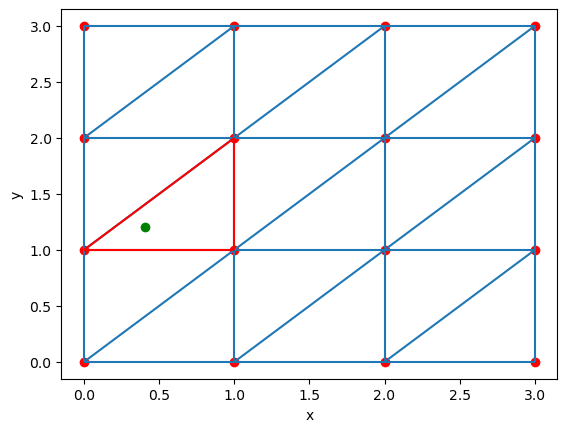

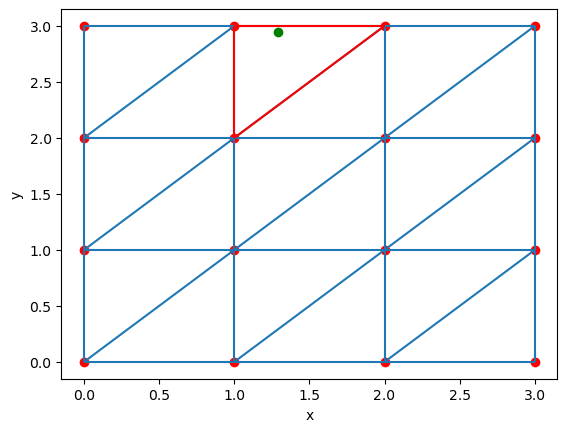

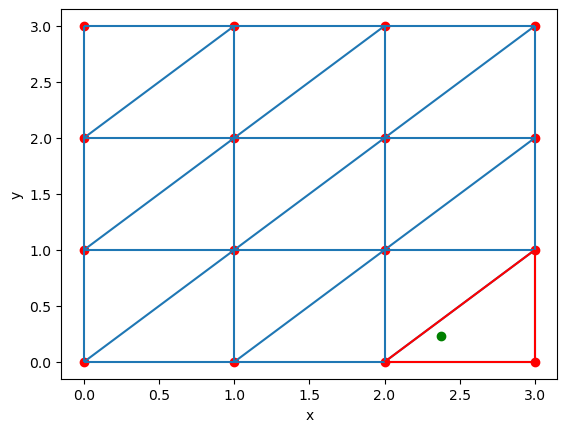

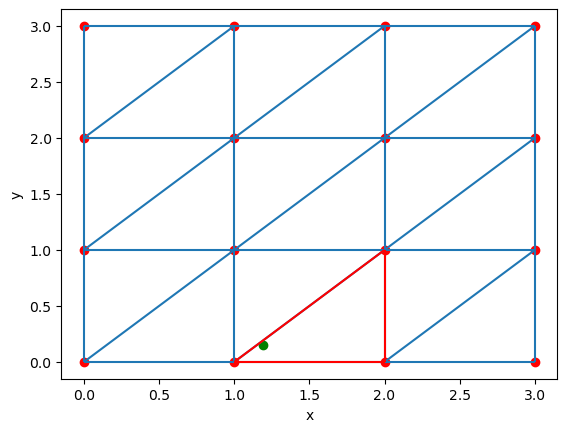

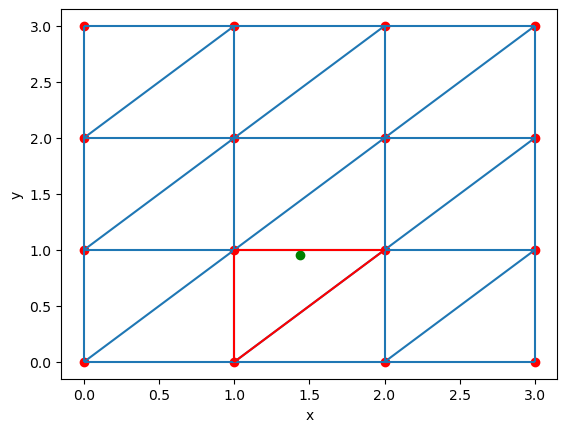

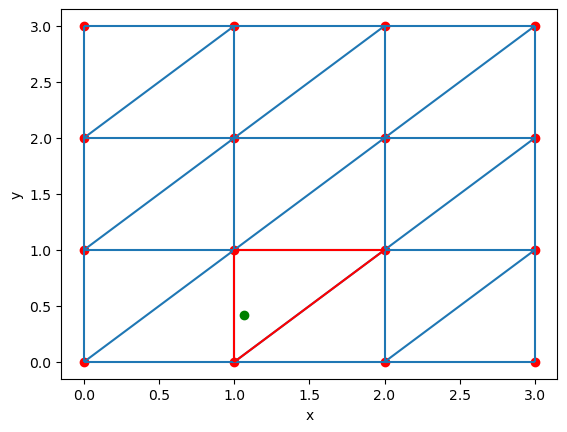

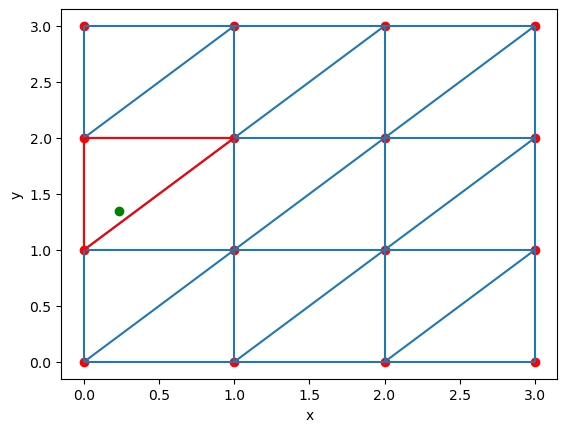

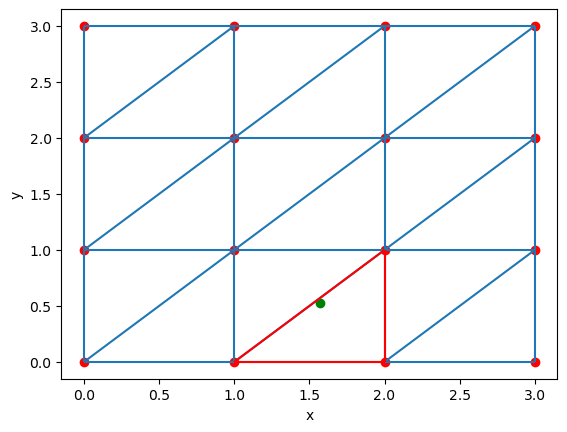

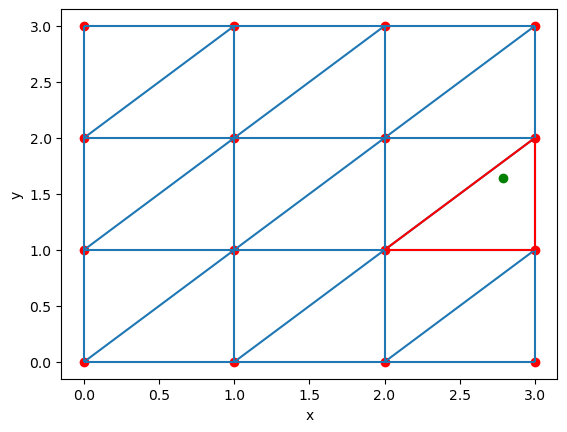

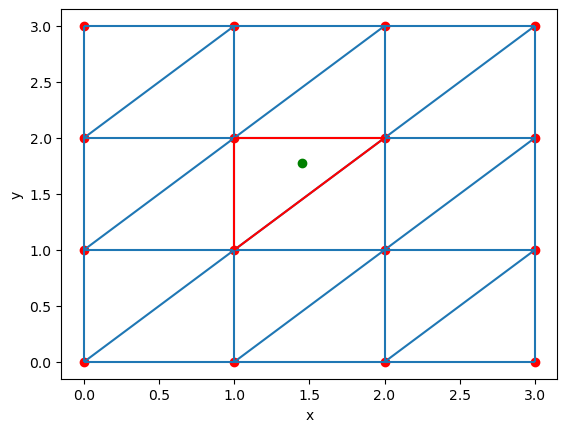

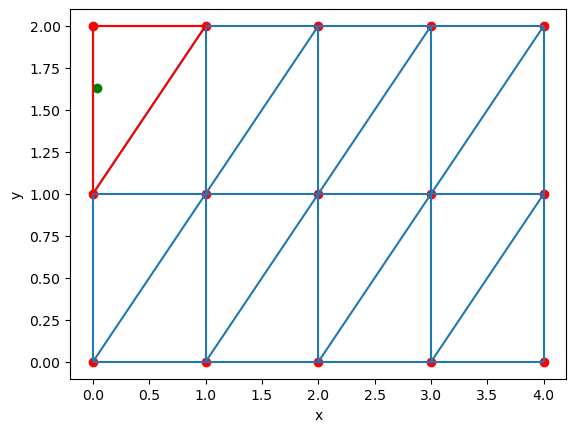

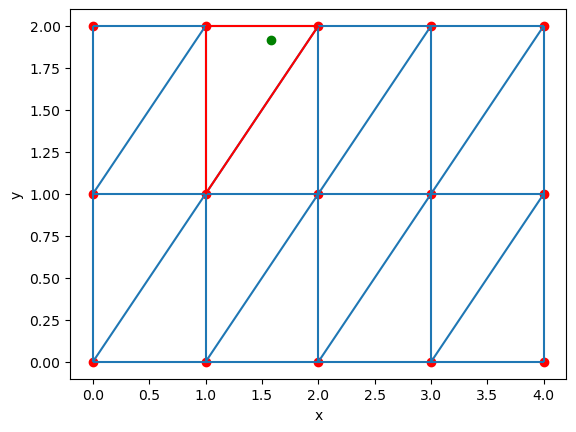

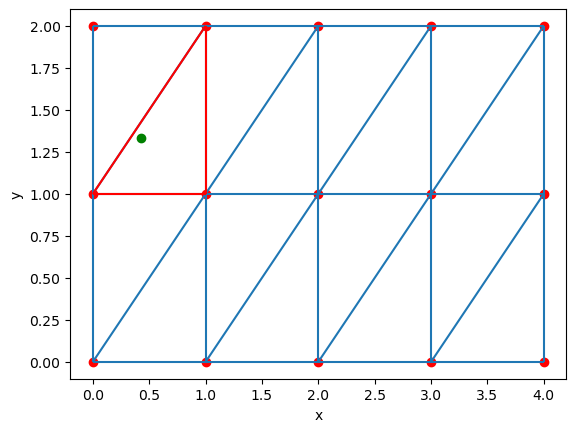

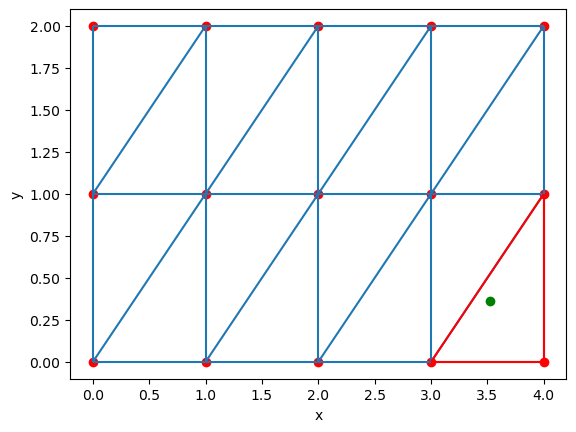

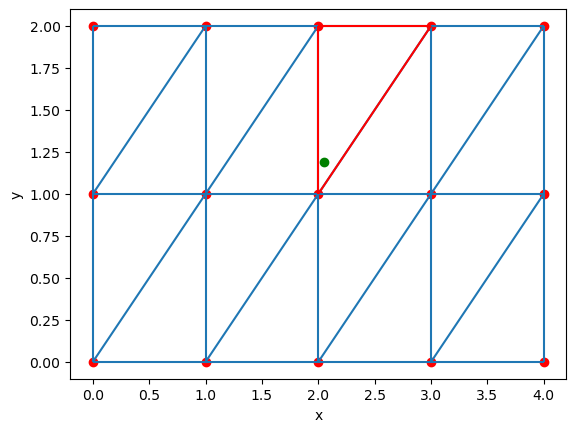

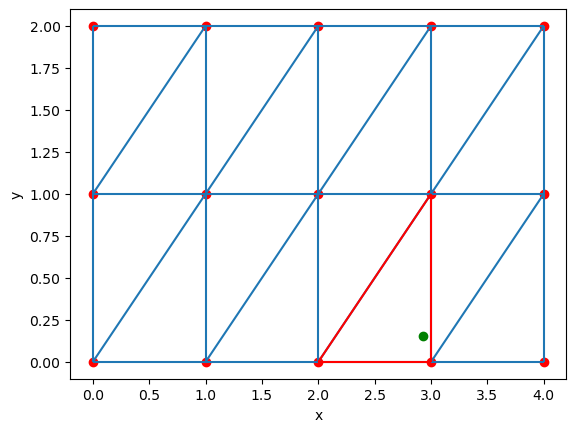

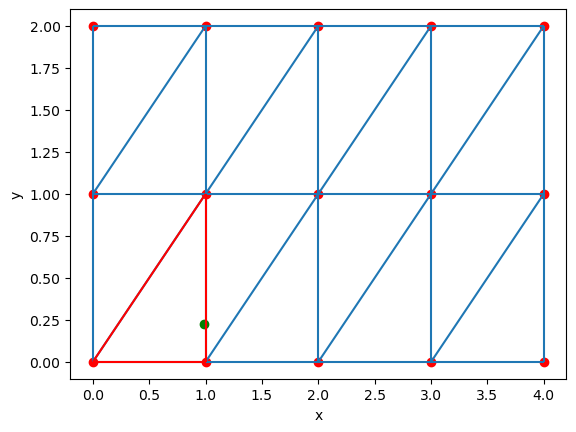

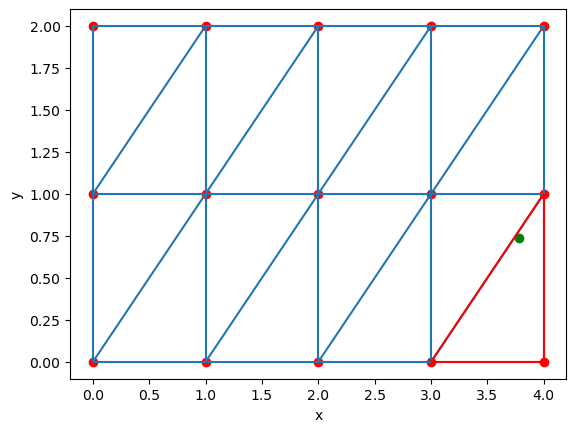

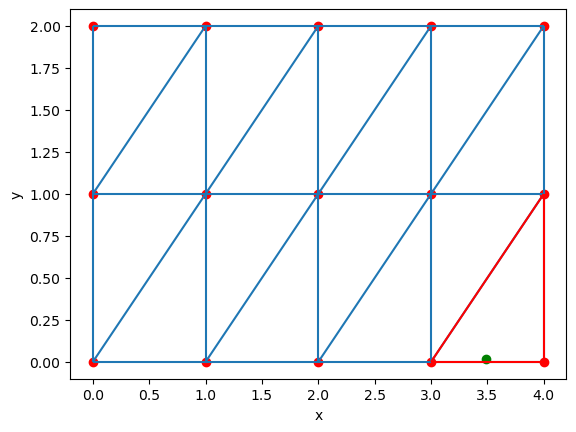

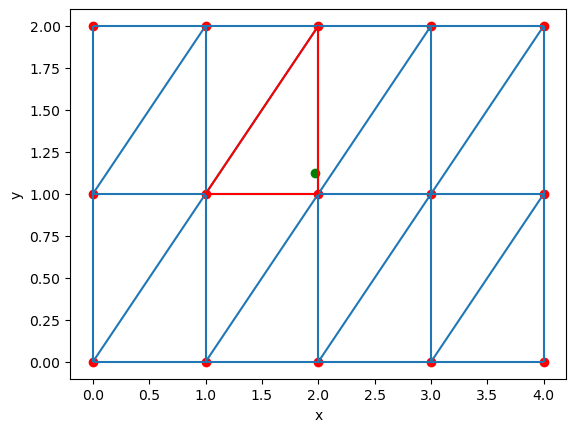

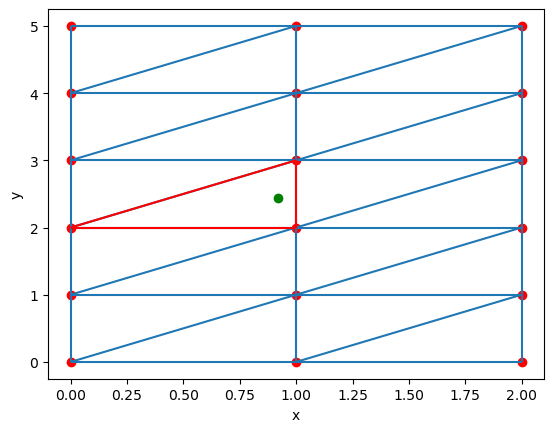

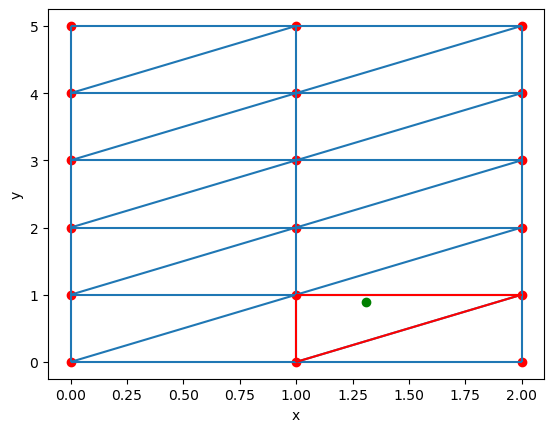

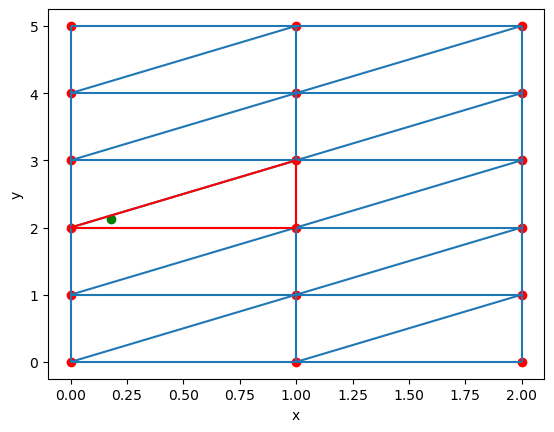

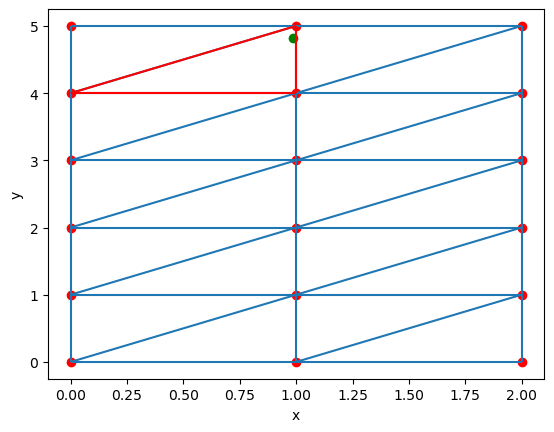

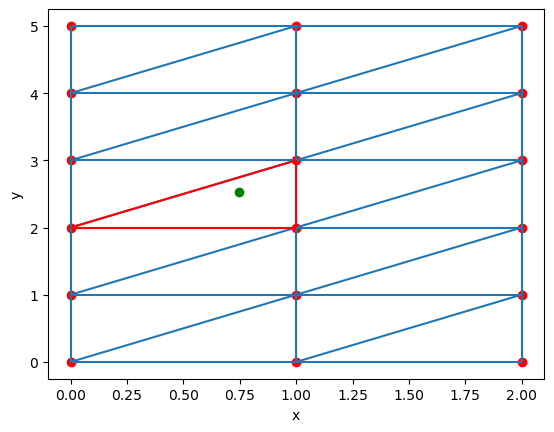

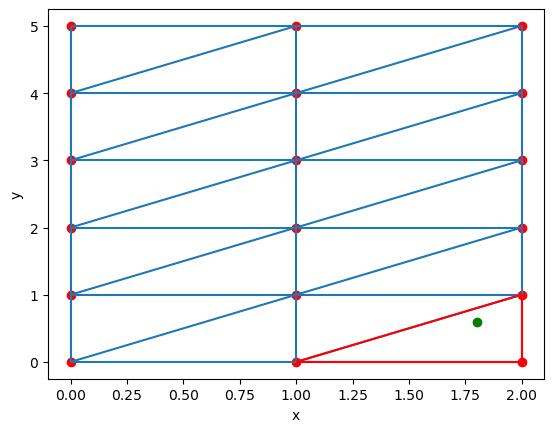

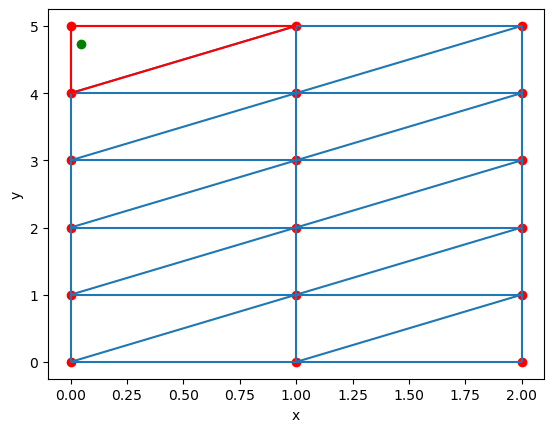

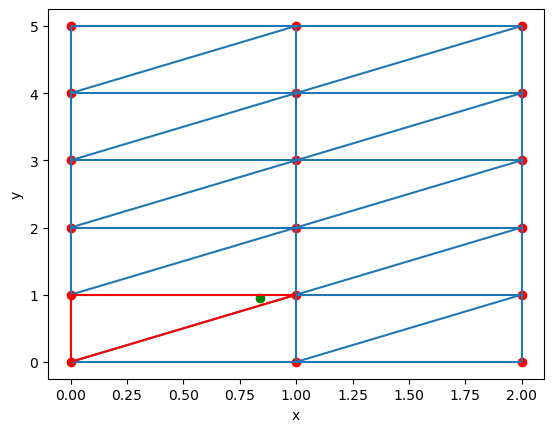

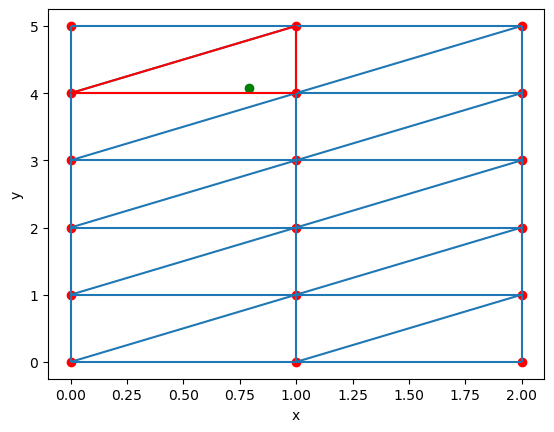

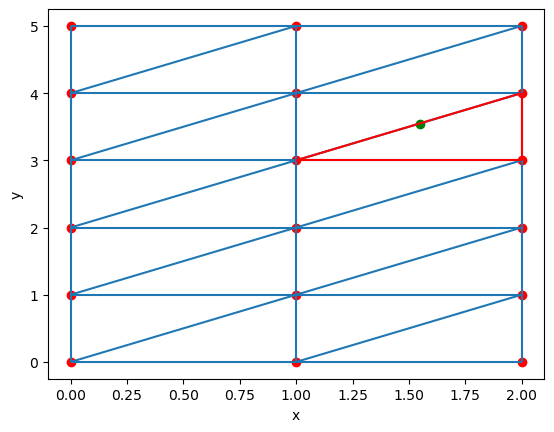

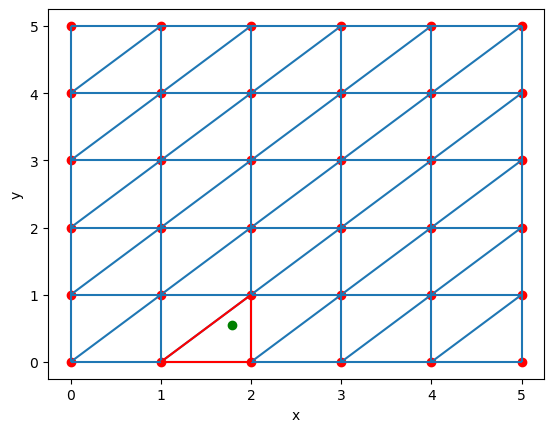

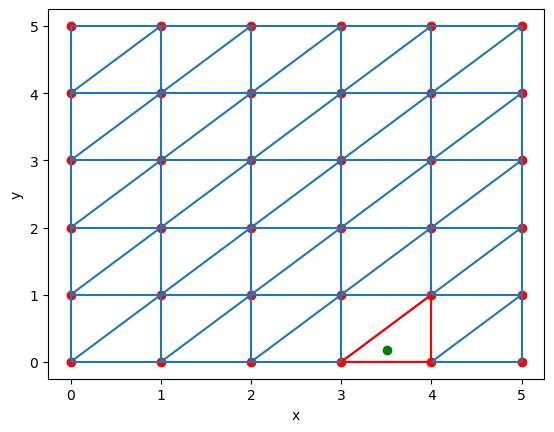

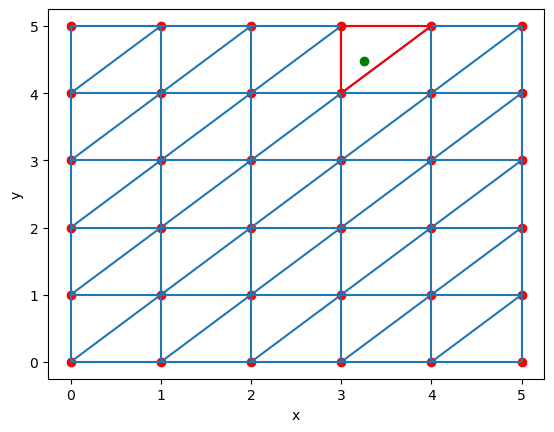

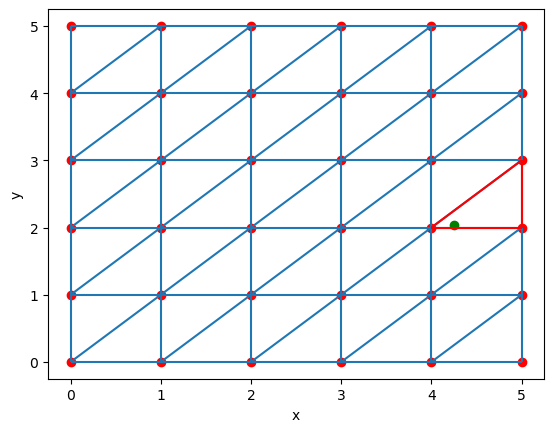

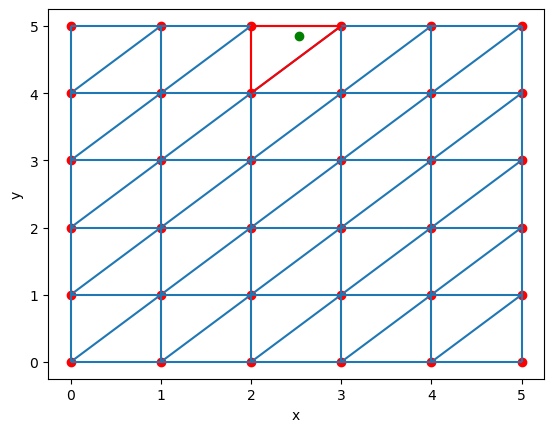

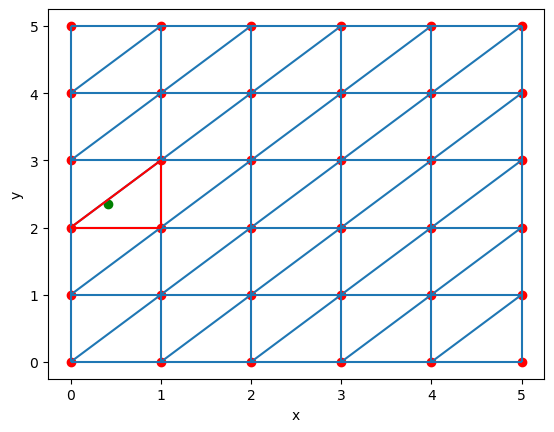

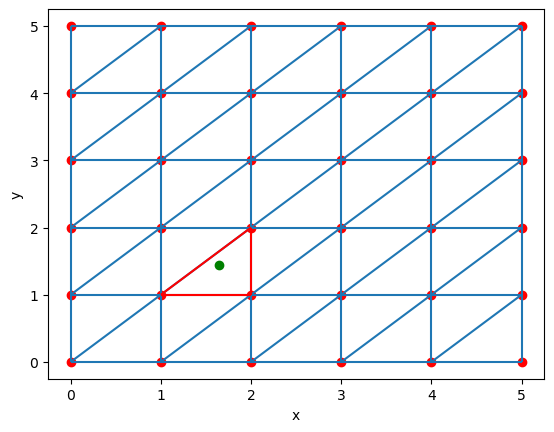

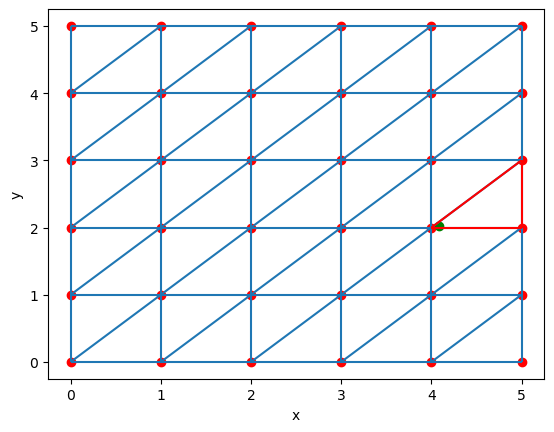

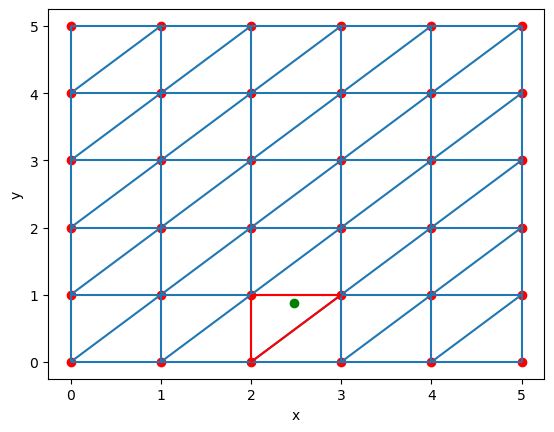

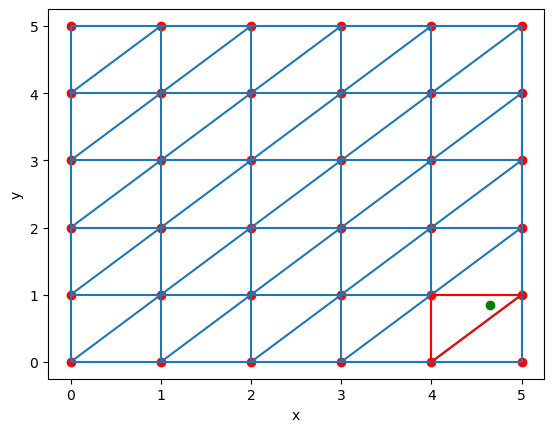

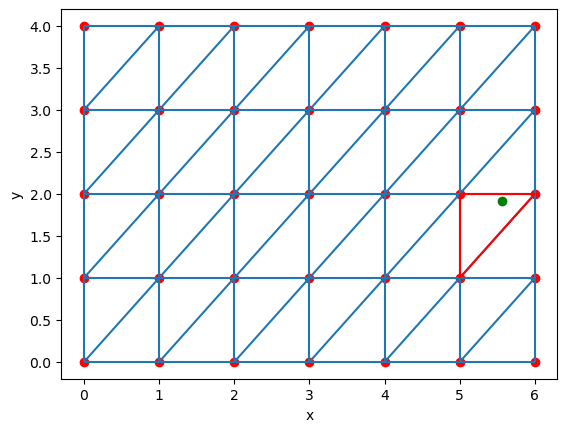

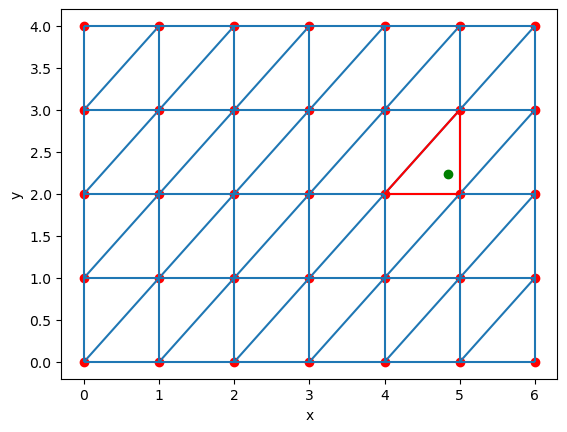

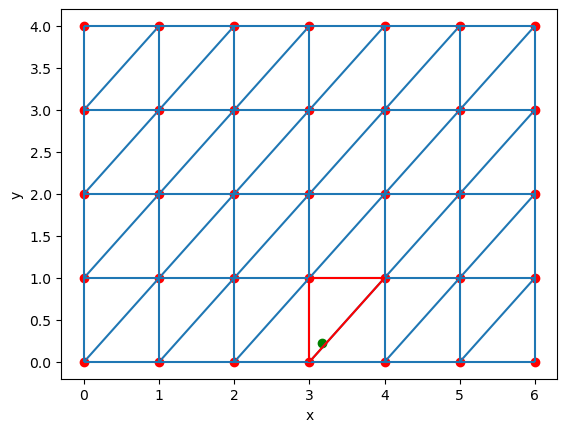

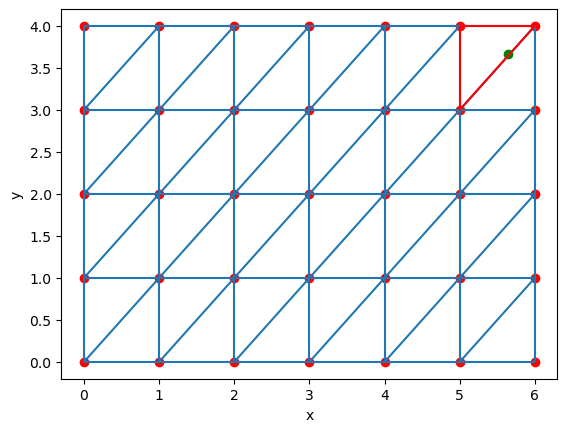

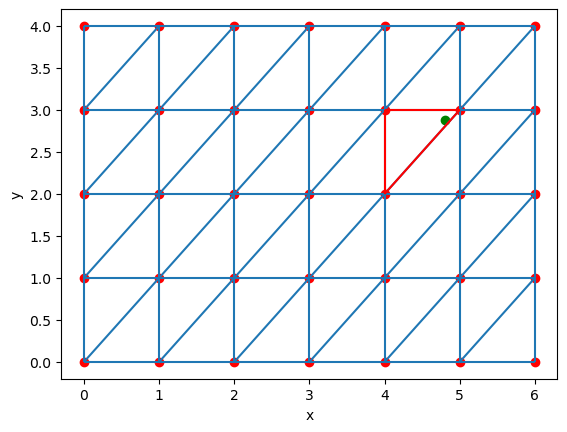

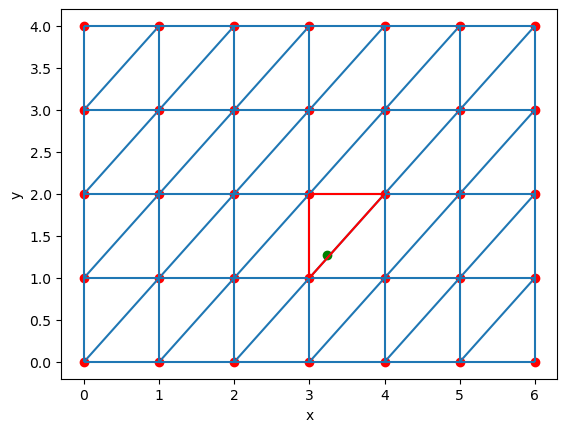

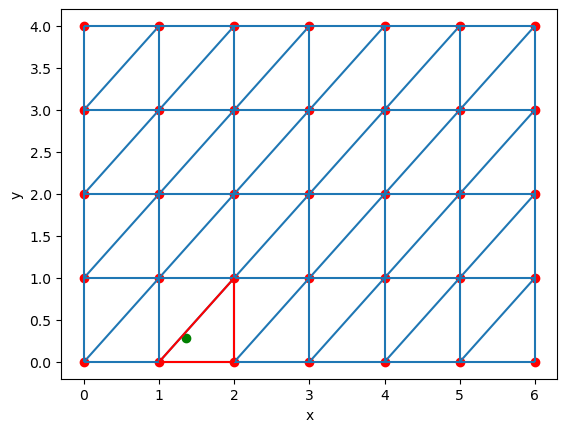

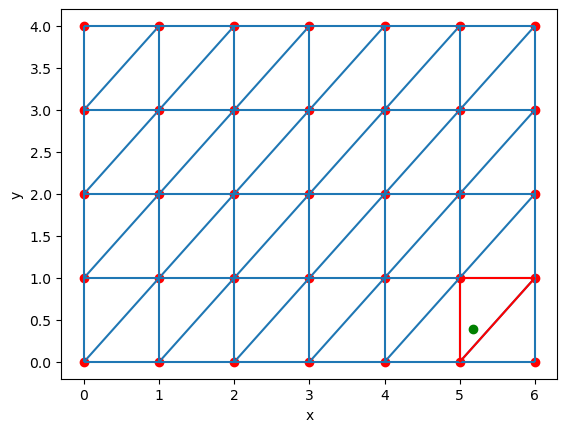

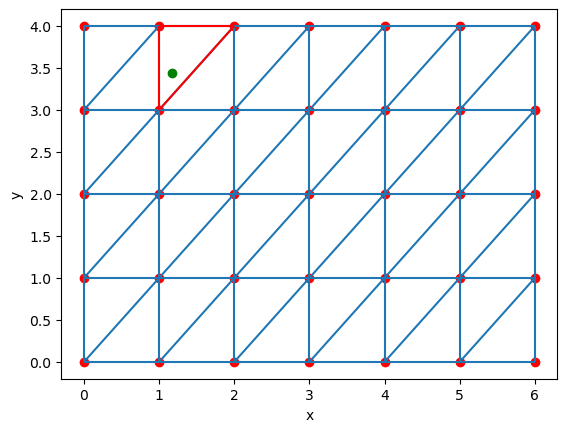

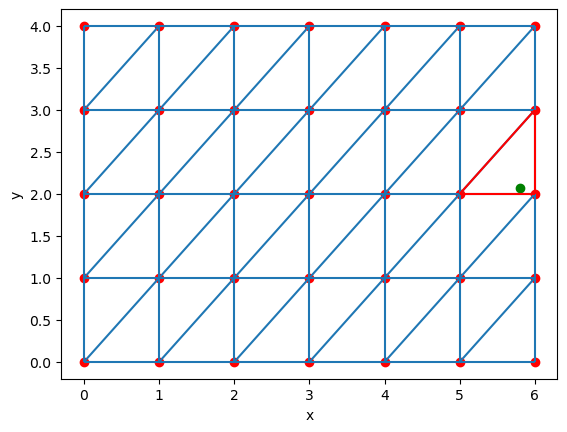

In [4]:
import random
import matplotlib.pyplot as plt

# 1. Funkcja generująca graf (siatkę)
def generate_grid_graph(width, height):
    """
    Generuje wierzchołki i krawędzie dla siatki o wymiarach width x height.
    Zwraca format zgodny z loadData: wierzchołki jako (x,y), krawędzie jako (idx1, idx2).
    """
    vertices = []
    edges = []
    
    # Generowanie wierzchołków
    for y in range(height + 1):
        for x in range(width + 1):
            vertices.append((float(x), float(y)))

    def get_idx(x, y):
        return y * (width + 1) + x

    # Generowanie krawędzi
    for y in range(height):
        for x in range(width):
            u = get_idx(x, y)
            right = get_idx(x + 1, y)
            top = get_idx(x, y + 1)
            top_right = get_idx(x + 1, y + 1)

            edges.append((u, right))
            edges.append((u, top))
            edges.append((right, top_right))
            edges.append((top, top_right))
            edges.append((u, top_right)) # Przekątna

    # Usuwanie duplikatów krawędzi
    unique_edges = set()
    for u, v in edges:
        if u < v: unique_edges.add((u, v))
        else: unique_edges.add((v, u))
            
    return vertices, list(unique_edges)

# 2. Definicja 5 scenariuszy (wymiary siatek)
scenarios = [
    {"dim": (3, 3), "desc": "Siatka 3x3 (18 trójkątów)"},
    {"dim": (4, 2), "desc": "Siatka 4x2 (16 trójkątów)"},
    {"dim": (2, 5), "desc": "Siatka 2x5 (20 trójkątów)"},
    {"dim": (5, 5), "desc": "Siatka 5x5 (50 trójkątów)"},
    {"dim": (6, 4), "desc": "Siatka 6x4 (48 trójkątów)"}
]

# 3. Pętla testowa
for s_idx, scen in enumerate(scenarios):
    w, h = scen["dim"]
    desc = scen["desc"]
    
    #print(f"\n{'='*60}")
    #print(f"SCENARIUSZ {s_idx + 1}: {desc}")
    #print(f"{'='*60}")
    
    # Generowanie grafu
    vertices, edges = generate_grid_graph(w, h)
    
    # Generowanie 10 losowych punktów wewnątrz obszaru siatki
    points_to_check = []
    for _ in range(10):
        # Losujemy floaty w zakresie (0, width) i (0, height)
        px = random.uniform(0, w)
        py = random.uniform(0, h)
        points_to_check.append((px, py))
        
    # Uruchomienie testów dla punktów
    for p_idx, point in enumerate(points_to_check):
        #print(f"  -> Punkt {p_idx + 1:02d}: ({point[0]:.2f}, {point[1]:.2f})")
        
        try:
            # Uruchomienie Twojego algorytmu wizualizującego
            vis_obj, found_edges = separators_method_point_location_algorithm_visualiser(
                vertices, 
                edges, 
                point
            )
            
            # Wypisanie znalezionych krawędzi (opcjonalne, dla weryfikacji)
            # print(f"     Znaleziono obszar ograniczony przez: {found_edges}")
            
            # Wyświetlenie wizualizacji
            vis_obj.show()
            
        except Exception as e:
            print(f"     [BŁĄD] Nie udało się zlokalizować punktu: {e}")